In [1]:
!pip install rectools==0.12.0

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.4/761.4 kB 58.0 kB/s  0:00:12 eta 0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--0m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.8 kB/s  0:00:24m0:00:0100:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 61.2 kB/s  0:08:46m0:00:0300:15
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [rectools]/11 [pydantic]


# Семинар "Простые модели в RecSys"
- **Датасет онлайн-кинотеатра Kion**
- **Фреймворк для рекомендательных систем от МТС RecTools**

- Практика построения валидации и кросс-валидации time-based
- Практика преобразования данных, специфичная для RecSys: матрица интеракций, маппинг айдишников
- Практика обучения простых моделей (а также что происходит под капотом):
    - Популярное
    - Популярное в категориии
    - itemKNN
    - EASE
- Практика оценки качества моделей (Accuracy, Beyond-accuracy, Popularity bias)
- Практика написания собственной модели (цепь Маркова первого порядка)
- Практика добавления эвристик

In [3]:
import typing as tp
from tqdm.auto import tqdm
import warnings

import pandas as pd
import numpy as np
import scipy
from scipy import sparse

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

In [4]:
from rectools.metrics import (
    Precision,
    NDCG,
    IntraListDiversity,
    Serendipity,
    AvgRecPopularity,
    MeanInvUserFreq,
    PairwiseHammingDistanceCalculator
)

import implicit
from implicit.nearest_neighbours import CosineRecommender
import rectools
from rectools import AnyIds, Columns, InternalIds
from rectools.dataset import Dataset
from rectools.models import ImplicitItemKNNWrapperModel, EASEModel, PopularModel, RandomModel, PopularInCategoryModel
from rectools.models.base import ModelBase, Scores
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.types import InternalIdsArray

Для запуска данного ноутбука достаточно сделать `pip install rectools==0.6.0`

In [5]:
print(pd.__version__)
print(np.__version__)
print(rectools.__version__)
print(implicit.__version__)
print(scipy.__version__)


2.2.3
1.26.4
0.12.0
0.7.2
1.12.0


# Датасет KION

In [8]:
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

zsh:1: command not found: wget
unzip:  cannot find or open data_original.zip, data_original.zip.zip or data_original.zip.ZIP.
rm: data_original.zip: No such file or directory


In [7]:
interactions = pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data_original/interactions.csv'

- переименуем колонки в универсальный формат для удобствва

In [ ]:

print(Columns.Weight)
print(Columns.Datetime)
interactions = interactions.rename(
    columns={'total_dur': Columns.Weight, 'last_watch_dt': Columns.Datetime}
)

weight
datetime


## ⭐️ interactions

Пользователь такой-то посмотрел фильм такой-то столько-то секунд и последняя дата просмотра была тогда-то (просмотры агрегируются). Просмотры назвываются в общем случае взаимодействиями

In [ ]:
pd.concat([interactions.head(), interactions.tail()])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.000000
1,699317,1659,2021-05-29,8317,100.000000
2,656683,7107,2021-05-09,10,0.000000
3,864613,7638,2021-07-05,14483,100.000000
4,964868,9506,2021-04-30,6725,100.000000
5476246,648596,12225,2021-08-13,76,0.000000
5476247,546862,9673,2021-04-13,2308,49.000000
5476248,697262,15297,2021-08-20,18307,63.000000
5476249,384202,16197,2021-04-19,6203,100.000000
5476250,319709,4436,2021-08-15,3921,45.000000


In [ ]:
print(f"Interactions shape {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")
print(f"min date in interactions: {interactions['datetime'].min()}")
print(f"max date in interactions: {interactions['datetime'].max()}")

Interactions shape (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706
min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


## ⭐️ users

Признаки пользователя = соцдем по пользователю (предсказанный моделью)

Используем в моделях, после экспериментов с более простыми моделями

In [ ]:
pd.concat([users.head(), users.tail()])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [ ]:
print(f"Users shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users shape (840197, 5)
Unique users: 840_197


## ⭐️ items

Признаки по айтему - их обычно достаточно много. Можно обогащать внешними источниками по желанию.

Используем в моделях, после экспериментов с более простыми моделями

In [ ]:
pd.concat([items.head(2), items.tail(2)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,"2,002.000000","драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,"2,014.000000","зарубежные, приключения, комедии",США,NaN,16.000000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
15961,4538,series,Среди камней,Darklands,"2,019.000000","драмы, спорт, криминал",Россия,0.000000,18.000000,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,"2,019.000000",комедии,Россия,0.000000,16.000000,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


In [ ]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 14)
Unique item_id: 15_963


## Train test split (по времени!)

In [ ]:
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] < max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] >= max_date - pd.Timedelta(days=7))]

# оставляем только горячих пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 5)
test: (349088, 5)


# Готовим данные в правильном формате



### Создаем `rectools.Dataset`, куда отправляем наш train

Зачем так сложно? Почему нельзя просто работать с interactions (взаимодействиями)?

В случае простого `.head(N)` может и возможно, но другие модели рекомендательных систем требуют хранения множества дополнительных вещей, например:

- маппинга вида `исходный юзер / айтем id` - `внутренний юзер / айтем id`
- просмотренных айтемов для каждого юзера, которые желательно потом удалить из рекомендованных
- правильное хранения фичей в дсотупном для моделей формате
- и тд

Поэтому приходим к тому, что проще инкапсулировать все эти свойства в один класс и передавать его объект в другие методы

In [ ]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

Внутри rectools.Dataset хранит интеракции уже во "внутренних" айдишниках юзеров и айтемов (инты, начиная с нуля)

In [ ]:
dataset.interactions.df.head(2)

,user_id,item_id,weight,datetime
0,0,0,"4,250.000000",2021-05-11
1,1,1,"8,317.000000",2021-05-29


А также маппинги

In [ ]:
dataset.user_id_map.convert_to_external([0, 1])

array([176549, 699317])

In [ ]:
dataset.item_id_map.convert_to_external([0, 1])

array([9506, 1659])

И имеет возможность вернуть "сырые" интеракции (смотрим, что все айди совпали)

In [ ]:
dataset.get_raw_interactions().head(2)

,user_id,item_id,weight,datetime
0,176549,9506,"4,250.000000",2021-05-11
1,699317,1659,"8,317.000000",2021-05-29


Внутренние айди - это индексы строк и столбцов в sparse матрице интеракций, которая используется многими моделями для обучения (коллаборативные KNN модели, линейные автоэнкодеры, матричные факторизации)

In [ ]:
dataset.get_user_item_matrix()

<896791x15565 sparse matrix of type '<class 'numpy.float32'>'
	with 4985269 stored elements in Compressed Sparse Row format>

Интеракции юзера с внутренним айди 0. Нули в матрице - отсутствие взаимодействий

In [ ]:
dataset.get_user_item_matrix()[0].toarray()

array([[4250., 5147.,    0., ...,    0.,    0.,    0.]], dtype=float32)

## Классический бейзлайн: Топ популярного

In [ ]:
pop = PopularModel()

pop.fit(dataset)

pop_recs = pop.recommend(
    users=test[Columns.User].unique(),
    dataset=dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

pop_recs.merge(items[['item_id', 'title', 'genres']],
                           on='item_id',
                           how='left').head(10)

,user_id,item_id,score,rank,title,genres
0,203219,10440,"187,877.000000",1,Хрустальный,"триллеры, детективы"
1,203219,15297,"178,630.000000",2,Клиника счастья,"драмы, мелодрамы"
2,203219,9728,"117,779.000000",3,Гнев человеческий,"боевики, триллеры"
3,203219,13865,"113,875.000000",4,Девятаев,"драмы, военные, приключения"
4,203219,4151,"85,117.000000",5,Секреты семейной жизни,комедии
5,203219,3734,"68,835.000000",6,Прабабушка легкого поведения,комедии
6,203219,2657,"66,017.000000",7,Подслушано,"драмы, триллеры"
7,203219,4880,"52,909.000000",8,Афера,комедии
8,203219,142,"42,466.000000",9,Маша,"драмы, триллеры"
9,203219,6809,"39,320.000000",10,Дуров,документальное


# Разнообразим модель: Популярное с лимитом по категориям


https://rectools.readthedocs.io/en/latest/api/rectools.models.popular_in_category.PopularInCategoryModel.html

Добавим в полку рекомендаций юзеров разнообразия по жанрам

In [ ]:
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head()

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии"
3,"[драмы, зарубежные, мелодрамы]","драмы, зарубежные, мелодрамы"
4,"[драмы, спорт, советские, мелодрамы]","драмы, спорт, советские, мелодрамы"


In [ ]:
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [ ]:
genre_feature = genre_feature[genre_feature['id'].isin(train['item_id'])]

In [ ]:
dataset_feature = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre']
)

Мы хотим оценивать Intra-List Diversity в ходе валидации. Для этого нам нужны вектора айтемов, по которым мы будем оценивать их близость. Возьмём жанры фильмов.

In [ ]:
# Вытащим дамми векторы жанров из датасета, чтобы считать на них разнообразие айтемов внутри полки
# Здесь только жанры, потому что это единственная фича для айтемов, которую мы передали в датасет
item_genre_dummies = dataset_feature.item_features.get_dense()
item_genre_dummies[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
genres_dummies_df = pd.DataFrame(item_genre_dummies)
genres_dummies_df.head()

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Для подачи в калькулятор расстояний из rectools мы должны в качестве индекса датафрейма поставить айди айтемов из датасета

index = dataset.item_id_map.get_external_sorted_by_internal()
print(index.shape)
print(genres_dummies_df.shape)
index

(15565,)
(15565, 158)


array([ 9506,  1659,  7107, ..., 13516, 13019, 10542])

In [ ]:
# Подставляем индекс и проверяем, что всё ок
genres_dummies_df.set_index(index, inplace=True)
genres_dummies_df.head()

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
9506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1659,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7107,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Готовим метрику Разнообразия внутри листа рекомендаций
distance_calculator = PairwiseHammingDistanceCalculator(genres_dummies_df)
ild = IntraListDiversity(10, distance_calculator=distance_calculator)

In [ ]:
pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5, )
pop_cat.fit(dataset_feature)  # подаём датасет с фичёй жанра

pop_recs_cat = pop_cat.recommend(
    test[Columns.User].unique(),
    dataset=dataset_feature,
    k=10,
    filter_viewed=True
)

pop_recs_cat.merge(items[['item_id', 'title', 'genres']],
                                   on='item_id',
                                   how='left').head(10)

,user_id,item_id,score,rank,title,genres
0,699317,15297,"178,630.000000",1,Клиника счастья,"драмы, мелодрамы"
1,699317,9728,"117,779.000000",2,Гнев человеческий,"боевики, триллеры"
2,699317,12192,"31,011.000000",3,Фемида видит,"драмы, детективы, комедии"
3,699317,7829,"17,604.000000",4,Поступь хаоса,"боевики, фантастика, фэнтези, приключения"
4,699317,849,"13,592.000000",5,Дебошир,"историческое, биография, криминал, драмы, спор..."
5,699317,13865,"113,875.000000",6,Девятаев,"драмы, военные, приключения"
6,699317,1844,"23,939.000000",7,Аферистка,"триллеры, комедии"
7,699317,7107,"16,279.000000",8,Девятаев,"драмы, военные, приключения"
8,699317,2657,"66,017.000000",9,Подслушано,"драмы, триллеры"
9,699317,16166,"12,664.000000",10,Зверополис,"приключения, мультфильм, детективы, комедии"


Посмотрим метрики

In [ ]:
Precision(k=10).calc(pop_recs, test)

0.030466565437814785

In [ ]:
# Precision упал
Precision(k=10).calc(pop_recs_cat, test)

0.02697334030318871

In [ ]:
AvgRecPopularity(k=10, normalize=True).calc(pop_recs, train)

0.01911281016129721

In [ ]:
# Popularity bias снизился
AvgRecPopularity(k=10, normalize=True).calc(pop_recs_cat, train)

0.01082558128399241

In [ ]:
ild.calc(pop_recs)

2.8666666666666667

In [ ]:
# Diversity внутри листа рекомендаций увеличился
ild.calc(pop_recs_cat)

5.21016842895219

# Item KNN

In [ ]:
cosine = ImplicitItemKNNWrapperModel(CosineRecommender(K=5))
cosine.fit(dataset)
cosine.model.similarity

<15565x15565 sparse matrix of type '<class 'numpy.float64'>'
	with 77229 stored elements in Compressed Sparse Row format>

В ходе метода `fit` была рассчитана разреженная item-item similarity матрица с ближайшими соседями

Посмотрим ближайших соседей к айтему с внутренним айди `0`

In [ ]:
_,  cosine_similar_items = cosine.model.similarity[0].nonzero()
print(f"Similar_items: {cosine_similar_items}")
scores = cosine.model.similarity[0, cosine_similar_items].toarray()
print(f"Similarity score: {scores}")

Similar_items: [    0   758  1333  2607 13361]
Similarity score: [[1.         0.19141153 0.27848838 0.13393534 0.10449729]]


Посмотрим рекомендации к айтему в внутренним id `0` из интерфейса rectools. Видим, что их и впрямь всего 4 (профильтровываем таргет)

In [ ]:
zero_reco = cosine.recommend_to_items(
    k=10,
    target_items=dataset.item_id_map.convert_to_external([0]),
    dataset=dataset,
    filter_itself=True)
zero_reco.merge(
    items[['item_id', 'title', 'genres']],
    on='item_id',
    how='left'
).head(10)

# Несмотря на запрос 10 рекомендаций мы видим всего 4 айтема в ответе. Это специфика модели

,target_item_id,item_id,score,rank,title,genres
0,9506,7582,0.278488,1,Холодное сердце II,"фэнтези, мультфильм, музыкальные"
1,9506,1105,0.191412,2,Рапунцель: Запутанная история,"мультфильм, приключения, мюзиклы, мелодрамы, ф..."
2,9506,9138,0.133935,3,Гномы в деле!,"семейное, развлекательные, мультфильмы"
3,9506,14863,0.104497,4,День труда,"драмы, триллеры, мелодрамы"


In [ ]:
# Посчитаем рекомендации на тесте для расчёта метрик

cos_reco = cosine.recommend(
    k=10,
    users=test[Columns.User].unique(),
    dataset=dataset,
    filter_viewed=True
)

In [ ]:
# Снизили Precision
Precision(k=10).calc(cos_reco, test)

0.017374853757498816

In [ ]:
# Очень ощутимо снилизи popularity bias
AvgRecPopularity(k=10, normalize=True).calc(cos_reco, train)

0.006214660842536055

In [ ]:
# Только 72% юзеров имеют заполненные списки рекомендаций
# Это важно иметь ввиду!


from rectools.metrics import SufficientReco
SufficientReco(10).calc(cos_reco)


0.7219802013060832

# EASE

In [ ]:
ease = EASEModel()
ease.fit(dataset)

# Посмотрим на матрицу схожести айтемов
print(ease.weight.shape)
# Скоры схожести для айтема с внутренним айди `0`
ease.weight[0]

(15565, 15565)


array([ 0.0000000e+00, -1.4975690e-03, -5.1239651e-04, ...,
       -3.2838457e-07,  5.1437854e-09,  1.8689409e-08], dtype=float32)

Как с технической точки зрения считаются рекомендации на таких скорах?

In [ ]:
ease_scores = ease.weight[0]
n_reco = 20

unsorted_reco_positions = ease_scores.argpartition(-n_reco)[-n_reco:]
unsorted_reco_scores = ease_scores[unsorted_reco_positions]
sorted_reco_ids = unsorted_reco_positions[unsorted_reco_scores.argsort()[::-1]]
reco_scores = ease_scores[sorted_reco_ids]

Есть ли пересечения с ближайшими соседями от itemKNN модели?

In [ ]:
cosine_similar_items

array([    0,   758,  1333,  2607, 13361], dtype=int32)

In [ ]:
sorted_reco_ids

array([1333,  758,  662, 3751,  318, 2954,  133,  850,  490,   11, 1033,
         72, 1087,   14,  201,  206,  486, 4162, 1082, 2839])

2 из 5 ближайших соседей попали в топ 20 EASE

In [ ]:
sum(np.isin(cosine_similar_items, sorted_reco_ids))

2

Посмотрим, какие рекомендации даёт EASE для айтема с внутренним айди `0`.
За счёт dense матрицы модель выдаёт полный список рекомендаций

In [ ]:
ease_reco = ease.recommend_to_items(
    k=10,
    target_items=dataset.item_id_map.convert_to_external([0]),
    dataset=dataset,
    filter_itself=True)
ease_reco.merge(
    items[['item_id', 'title']],
    on='item_id',
    how='left'
)

,target_item_id,item_id,score,rank,title
0,9506,7582,0.272160,1,Холодное сердце II
1,9506,1105,0.120084,2,Рапунцель: Запутанная история
2,9506,13867,0.058548,3,Рио
3,9506,12741,0.049933,4,Шиммер и Шайн
4,9506,12225,0.044505,5,Фиксики
5,9506,5535,0.043156,6,Склифосовский
6,9506,14120,0.034050,7,Маша и Медведь
7,9506,5471,0.031626,8,Доктор Хаус
8,9506,6006,0.031233,9,Кости
9,9506,496,0.031085,10,Воскресший Эртугрул


Посчитаем метрики на тесте

In [ ]:
ease_reco_full = ease.recommend(
    k=10,
    users=test[Columns.User].unique(),
    dataset=dataset,
    filter_viewed=True)

In [ ]:
Precision(k=10).calc(ease_reco_full, test)

7.4677021880367405e-06

# Викторина!

Очень низкое значение Precision для модели, которую многие называют SOTA бейзлайном без нейронок на голых интеракциях. И легко запускают на продуктах первым MVP. Что пошло не так?

In [ ]:
# Наш трейн
train.head(2)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.000000
1,699317,1659,2021-05-29,8317,100.000000


In [ ]:
# Какую одну строчку нужно добавить (или изменить) в этом коде, чтобы получить "починить" модель?

dataset = Dataset.construct(train)
ease = EASEModel()
ease.fit(dataset)
ease_reco_ones = ease.recommend(
    k=10,
    users=test[Columns.User].unique(),
    dataset=dataset,
    filter_viewed=True)
Precision(k=10).calc(ease_reco_ones, test)
# Итоговый Precision будет:

0.02279391631195081

In [ ]:
# Ответ:

















# EASE и SLIM восстанавливают БИНАРНУЮ матрицу взаимодействий
train[Columns.Weight] = 1

# Строим удобную валидацию
Вручную делить на трейн и тест и считать метрики по одной для каждой обученной модели неудобно. Облегчаем себе жизнь

In [ ]:
k = 10
metrics = {
    "precision": Precision(k),
    "ndcg": NDCG(k),
    "serendipity": Serendipity(k),
    "pop_bias": AvgRecPopularity(k, normalize=True),
    "novelty": MeanInvUserFreq(k),
    "diversity": ild,
}
from rectools.metrics import Intersection
metrics["intersection"] = Intersection(k)

In [ ]:
splitter = TimeRangeSplitter(  # time-based валидация
    "7D",  # скользящее окно по 7 дней
    n_splits = 1,  # 1 фолд (делаем для ускорения расчётов)
    filter_cold_users=True,  # только hot юзеры в тесте
    filter_cold_items=True,  # только hot айтемы в тесте
    filter_already_seen=True  # дропаем из теста просмотры трейна
    )

Соберём модели и запустим кросс-валидацию по выбранной нами схеме

In [ ]:
models = {
    "pop": PopularModel(),
    "cat_pop": PopularInCategoryModel("genre", 5),
    "cosine": ImplicitItemKNNWrapperModel(CosineRecommender()),
    "ease": EASEModel(),
    "random": RandomModel(random_state=32)
}

In [ ]:
res = cross_validate(
    dataset_feature,
    splitter,
    metrics,
    models,
    k=10,
    filter_viewed=True,
    ref_models = models.keys(),
    validate_ref_models=True
)

In [ ]:
pd.DataFrame(res["metrics"])

,model,i_split,precision,ndcg,novelty,pop_bias,diversity,serendipity,intersection_pop,intersection_cat_pop,intersection_cosine,intersection_ease,intersection_random
0,pop,0,0.034412,0.043255,3.711600,0.016593,5.018034,0.000002,1.000000,0.468076,0.339553,0.000000,0.000600
1,cat_pop,0,0.025794,0.034227,4.555862,0.010988,4.676440,0.000008,0.468076,1.000000,0.219133,0.000001,0.000645
2,cosine,0,0.025375,0.030980,9.375491,0.006626,4.850174,0.000121,0.339556,0.219135,1.000000,0.011965,0.000650
3,ease,0,0.000009,0.000010,18.772681,0.000001,5.122576,0.000001,0.000000,0.000001,0.011965,1.000000,0.000630
4,random,0,0.000177,0.000185,15.658560,0.000061,4.578171,0.000006,0.000600,0.000645,0.000650,0.000630,1.000000


Заметили, что мы на кросс-валидацию отправляем датасет, собранный на трейне без последней недели интеракций? Наш тест остаётся нашей отложенной выборкой. Мы не будем пользоваться им в этом ноутбуке, но вполне могли бы, если бы делали модель для реального сервиса

# Напишем свою модель: TransitionsModel (first order Markov chain)
Допустим, мы не показываем фильмы, а рекомендуем (и продаём) телефоны. Тогда логичным бейзлайном будет предложить пользователю самую популярную модель, которую покупают сразу после его текущей модели чаще всего. По сути это цепь Маркова 1 порядка.  

Мы будем считать количество переходов (transitions) от каждого айтема к следующему в истории пользователей в нашем трейне.
Счётчики всех переходов между айтемами запишем в sparse матрицу размерности n_hot_items x n_hot_items.

При построении рекомендаций мы будем подтягивать последний айтем из истории юзера и предлагать ему те айтемы, которые чаще всего бывали следующими после него.

In [ ]:
# Наследуемся от rectools.models.ModelBase для использования модели в кросс-валидации
class TransitionsModel(ModelBase):
    """

    Parameters
    ----------
    verbose : int, default 0
        Degree of verbose output. If 0, no output will be provided.
    """

    recommends_for_warm = False
    recommends_for_cold = False

    def __init__(
        self,
        verbose: int = 0,
    ):
        super().__init__(verbose=verbose)
        self.weight: sparse.csr_matrix

    def _fit(self, dataset: Dataset) -> None:

        interactions = dataset.interactions.df
        # final transition scores will be written to a csr matrix
        # internal item ids correspond to row and col indexes of the matrix
        # rows are items to calc transisions from
        # cols are items that transition were made to
        self.weight = sparse.csr_matrix((dataset.n_hot_items, dataset.n_hot_items))

        # filter users with only one interactions because thay don't have transitions
        user_inter_count = interactions.groupby(Columns.User)[Columns.Item].count()
        actual = user_inter_count[user_inter_count] > 1
        interactions = interactions[interactions[Columns.User].isin(actual.index)].sort_values(["user_id", "datetime"])

        grouped = interactions.groupby("user_id")
        for _, group in tqdm(grouped, disable=self.verbose == 0):
            session = group["item_id"].values
            for i in range(len(session)-1):
                self.weight[session[i], session[i+1]] += 1

    def _recommend_u2i(
        self,
        user_ids: InternalIdsArray,
        dataset: Dataset,
        k: int,
        filter_viewed: bool,
        sorted_item_ids_to_recommend: tp.Optional[InternalIdsArray],
    ) -> tp.Tuple[InternalIds, InternalIds, Scores]:

        user_interactions = dataset.interactions.df[dataset.interactions.df[Columns.User].isin(user_ids)]
        last_interactions = (
            user_interactions
            .sort_values([Columns.User, Columns.Datetime])
            .groupby(Columns.User)
            .tail(1)
        )
        target_items = last_interactions[Columns.Item].unique()

        target_ids, reco_ids, scores = self._recommend_i2i(
            target_items, dataset, k, sorted_item_ids_to_recommend
        )
        last_item_scores = pd.DataFrame(
            {
                Columns.TargetItem: target_ids,
                Columns.Item: reco_ids,
                Columns.Score: scores
            }
        )
        unfiltered_reco = (
            last_interactions
            .rename(columns={Columns.Item: Columns.TargetItem})
            .merge(last_item_scores, "inner", Columns.TargetItem)
            .drop(Columns.TargetItem, axis=1)
        )
        if not filter_viewed:
            reco = unfiltered_reco
        else:
            reco = unfiltered_reco.merge(
                    dataset.interactions.df,
                    "outer",
                    Columns.UserItem,
                    indicator=True
                )
            reco = reco[reco["_merge"] == "left_only"]
        return reco[Columns.User].values, reco[Columns.Item].values, reco[Columns.Score].values


    def _recommend_i2i(
        self,
        target_ids: InternalIdsArray,
        dataset: Dataset,
        k: int,
        sorted_item_ids_to_recommend: tp.Optional[InternalIdsArray],
    ) -> tp.Tuple[InternalIds, InternalIds, Scores]:
        similarity = self.weight[target_ids].toarray()
        if sorted_item_ids_to_recommend is not None:
            similarity = similarity[:, sorted_item_ids_to_recommend]

        n_reco = min(k, similarity.shape[1])
        unsorted_reco_positions = similarity.argpartition(-n_reco, axis=1)[:, -n_reco:]
        unsorted_reco_scores = np.take_along_axis(similarity, unsorted_reco_positions, axis=1)

        sorted_reco_positions = unsorted_reco_scores.argsort()[:, ::-1]

        all_reco_scores = np.take_along_axis(unsorted_reco_scores, sorted_reco_positions, axis=1)
        all_reco_ids = np.take_along_axis(unsorted_reco_positions, sorted_reco_positions, axis=1)

        all_target_ids = np.repeat(target_ids, n_reco)

        if sorted_item_ids_to_recommend is not None:
            all_reco_ids = sorted_item_ids_to_recommend[all_reco_ids]

        # Filter zero scores
        scores = all_reco_scores.flatten()
        positive_mask = scores > 0
        scores = scores[positive_mask]
        reco_ids = all_reco_ids.flatten()[positive_mask]
        target_ids = all_target_ids[positive_mask]

        return target_ids, reco_ids, scores

In [ ]:
trn = TransitionsModel(verbose=1)
trn.fit(dataset)
reco = trn.recommend(
    test[Columns.User].unique(),
    dataset=dataset,
    k = 10,
    filter_viewed=True
)

  0%|          | 0/309 [00:00<?, ?it/s]

In [ ]:
# Почему такой низкий Precision?
Precision(10).calc(reco, test)

0.01045063433981364

In [ ]:
# Модель часто недозаполняет рекомендации (всего 27% тестовых юзеров получили полный список из 10 айтемов)
from rectools.metrics import SufficientReco
SufficientReco(10).calc(reco)

0.275036437557533

# Дополним свою модель: Fallback пайплайн
Если мы считаем, что на продукте TransitionModel нам может помочь для решения бизнес задачи, мы всё равно можем её использовать, но должны дополнить недостающие рекомендации другим алгоритмом

Оформим в виде класса, чтобы легко валидировать такой пайплайн наравне с обычными моделями

In [ ]:
class FallbackPipeline(ModelBase):

    recommends_for_warm = False
    recommends_for_cold = False

    def __init__(
        self,
        models: tp.List[ModelBase],
        verbose: int = 0
    ):
        super().__init__(verbose=verbose)
        self.models = models

    def _fit(self, dataset: Dataset) -> None:
        for model in self.models:
            model.fit(dataset)

    def recommend(
        self,
        users: AnyIds,
        dataset: Dataset,
        k: int,
        filter_viewed: bool,
        items_to_recommend: tp.Optional[AnyIds] = None,
        add_rank_col: bool = True,
        assume_external_ids: bool = True,
    ) -> pd.DataFrame:

        recos = [
            model.recommend(
                users,
                dataset,
                k,
                filter_viewed,
                items_to_recommend,
                add_rank_col=False,
                assume_external_ids=assume_external_ids
            ) for model in self.models
        ]
        final_reco = pd.concat(recos, ignore_index=True).drop_duplicates(subset=Columns.UserItem)
        final_reco = final_reco.groupby(Columns.User, sort=False).head(k)
        final_reco[Columns.Rank] = final_reco.groupby(Columns.User, sort=False).cumcount() + 1
        final_reco.sort_values([Columns.User, Columns.Rank], inplace=True)

        if not add_rank_col:
            del final_reco[Columns.Rank]

        return final_reco

In [ ]:
fb = FallbackPipeline([TransitionsModel(verbose=1), PopularModel()])
fb.fit(dataset)
reco_trn_fb = fb.recommend(
    test[Columns.User].unique(),
    dataset=dataset,
    k = 10,
    filter_viewed=True
)

  0%|          | 0/309 [00:00<?, ?it/s]

In [ ]:
# Проверим, что у юзеров все рекомендации не повторяются

from rectools.metrics import UnrepeatedReco
UnrepeatedReco(10).calc(reco_trn_fb)

1.0

In [ ]:
# Проверим, что теперь все списки для всех юзеров заполнены

from rectools.metrics import SufficientReco
SufficientReco(10).calc(reco_trn_fb)


1.0

In [ ]:
Precision(10).calc(reco_trn_fb, test)

0.02688621711099495

# Полный код валидации моделей

In [ ]:
binary_train = train.copy()
binary_train[Columns.Weight] = 1
binary_dataset = Dataset.construct(binary_train)

current_dataset = binary_dataset

test_models = {
    "pop": PopularModel(),
    "cosine_20": ImplicitItemKNNWrapperModel(CosineRecommender(20)),
    "cosine_5_w_cosine_20": FallbackPipeline([
        ImplicitItemKNNWrapperModel(CosineRecommender(5)),
        ImplicitItemKNNWrapperModel(CosineRecommender(20))
        ]),
    "trn": TransitionsModel(),
    "trn_w_cos_5_w_pop": FallbackPipeline([
        TransitionsModel(),
        ImplicitItemKNNWrapperModel(CosineRecommender(5)),
        PopularModel()]),
    "ease": EASEModel(5000)
}

k = 10
metrics = {
    "precision": Precision(k), # Это целевая метрика для задания, остальные можно убрать если они не интересны
    "ndcg": NDCG(k),
    "serendipity": Serendipity(k),
    "pop_bias": AvgRecPopularity(k, normalize=True),
    "novelty": MeanInvUserFreq(k), # Это целевая метрика для задания, остальные можно убрать если они не интересны
}

splitter = TimeRangeSplitter(  # time-based валидация
    "7D",  # скользящее окно по 7 дней
    n_splits = 1,  # 1 фолд (делаем для ускорения расчётов)
    filter_cold_users=True,  # только hot юзеры в тесте
    filter_cold_items=True,  # только hot айтемы в тесте
    filter_already_seen=True  # дропаем из теста просмотры трейна
)

res = cross_validate(
    current_dataset,
    splitter,
    metrics,
    test_models,
    k=10,
    filter_viewed=True,
)
metrics_res = pd.DataFrame(res["metrics"])
metrics_res

# Результаты можно сохранить в csv для логирования экспериментов
metrics_res.to_csv("seminar_final.csv", index=False)

,model,i_split,precision,ndcg,novelty,pop_bias,serendipity
0,pop,0,0.034412,0.043255,3.711600,0.016593,0.000002
1,cosine_20,0,0.037981,0.046083,5.766520,0.010408,0.000191
2,cosine_5_w_cosine_20,0,0.034065,0.042375,6.909196,0.008728,0.000251
3,trn,0,0.010262,0.013242,8.058459,0.004256,0.000113
4,trn_w_cos_5_w_pop,0,0.026506,0.028050,7.276794,0.007497,0.000192
5,ease,0,0.030746,0.034588,6.208630,0.006080,0.000161


## Посмотрим значения метрик на графиках

In [ ]:
from rectools.visuals import MetricsApp

import pandas as pd
metrics_res = pd.read_csv("seminar_final.csv")
app = MetricsApp.construct(metrics_res)

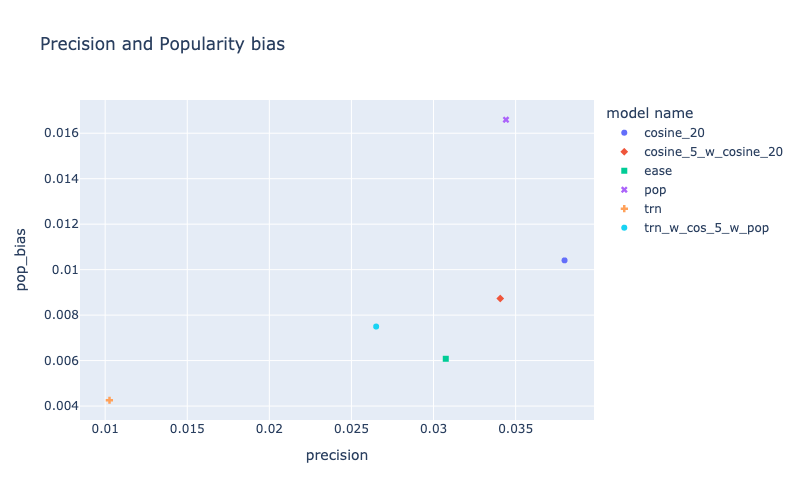

In [ ]:
# Высокий Precision часто приводит к высокому Popularity bias, но ряд моделей здесь может выгодно отличаться
app.fig.update_layout(title="Precision and Popularity bias").show("png")

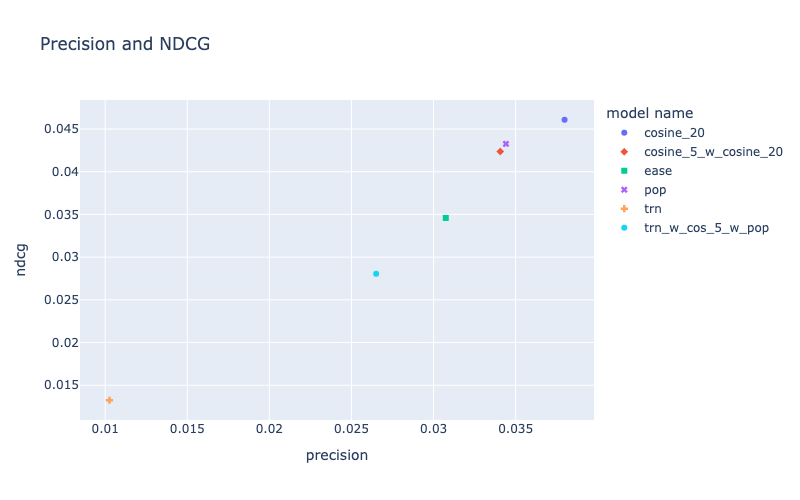

In [ ]:
# Классификационные и ранжирующие метрики имеют высокую корреляцию, но не всегда график будет ровной линией
app.fig.update_layout(title="Precision and NDCG").show("png")

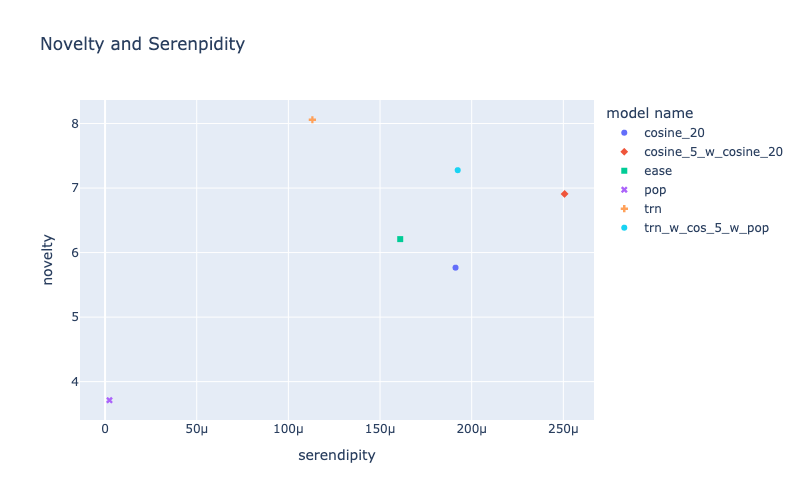

In [ ]:
# Высокая новизна не означает, что модель хорошо угадывает. Нет обязатльноей связки Novelty -> Serendipity
app.fig.update_layout(title="Novelty and Serenpidity").show("png")

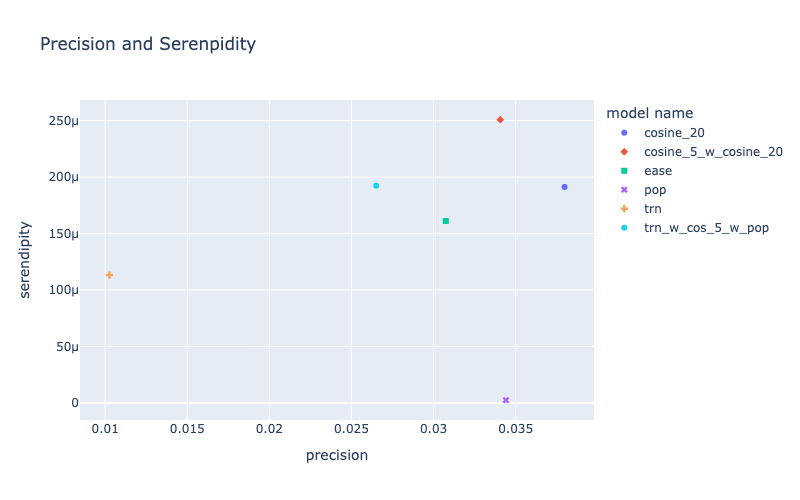

In [ ]:
# На продукте где popularity bias важно держать под контролем:
# Финальную модель можно выбирать по парето-оптимуму ранжирования/классификации и Serendipity
app.fig.update_layout(title="Precision and Serenpidity").show("png")

# Векторный расчёт метрик

In [ ]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].sort_values("user_id").reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df


,user_id,item_id
0,57607,4151
1,57607,10440
2,57607,13865
3,70720,4880
4,70720,4881
5,70720,6327
6,403227,6353
7,403227,1736
8,403227,5336
9,403227,181


In [ ]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)


Users [ 57607  70720 403227]
Items [ 4151 10440 13865  4880  4881  6327  6353  1736  5336   181]


In [ ]:
top_k = 5
recs = np.array([
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
])
recs


array([[  181, 13865,  4881,  1736,  5336],
       [ 4151, 10440,  6327,  5336,  6353],
       [ 1736,  4151,  4881,  6353, 13865]])

Преобразуем в длинный датафрейм и проставим ранг

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(sample_users, top_k),
    Columns.Item: recs.ravel()
})
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
df_recs


,user_id,item_id,rank
0,57607,13865,1
1,57607,6353,2
2,57607,10440,3
3,57607,6327,4
4,57607,5336,5
5,403227,5336,1
6,403227,4881,2
7,403227,181,3
8,403227,6353,4
9,403227,4151,5


Ключевой момент. Именно ради него преобразовывали данные и именно это позволяет считать метрики быстрее.

Мы получил датафрейм с тестовыми интеракциями и предсказанными рангом от модели.

In [ ]:
df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
df_recs = df_recs.sort_values(by=[Columns.User, Columns.Rank])
df_recs


,user_id,item_id,rank
2,57607,13865,1.000000
1,57607,10440,3.000000
0,57607,4151,NaN
5,70720,6327,4.000000
4,70720,4881,5.000000
3,70720,4880,NaN
8,403227,5336,1.000000
9,403227,181,3.000000
6,403227,6353,4.000000
7,403227,1736,NaN


### Precision@K

In [ ]:
df_recs[f'TP@5'] = df_recs['rank'] < 6
df_recs


,user_id,item_id,rank,TP@5
2,57607,13865,1.000000,True
1,57607,10440,3.000000,True
0,57607,4151,NaN,False
5,70720,6327,4.000000,True
4,70720,4881,5.000000,True
3,70720,4880,NaN,False
8,403227,5336,1.000000,True
9,403227,181,3.000000,True
6,403227,6353,4.000000,True
7,403227,1736,NaN,False


In [ ]:
df_recs[df_recs[Columns.Rank].notnull()]


,user_id,item_id,rank,TP@5
2,57607,13865,1.000000,True
1,57607,10440,3.000000,True
5,70720,6327,4.000000,True
4,70720,4881,5.000000,True
8,403227,5336,1.000000,True
9,403227,181,3.000000,True
6,403227,6353,4.000000,True


Посчитаем вручную Precision@5 (усредняем по юзерам): (2/5 + 3/5 + 2/5) / 3

In [ ]:
(2/5 + 2/5 + 3/5) / 3


0.4666666666666666

Посчитаем через groupby

In [ ]:
df_recs['TP@5/5'] = df_recs['TP@5'] / top_k

p5 = df_recs.groupby(Columns.User)['TP@5/5'].sum().mean()

print(f'Precision@5 = {p5}')


Precision@5 = 0.46666666666666673


In [ ]:
df_recs


,user_id,item_id,rank,TP@5,TP@5/5
2,57607,13865,1.000000,True,0.200000
1,57607,10440,3.000000,True,0.200000
0,57607,4151,NaN,False,0.000000
5,70720,6327,4.000000,True,0.200000
4,70720,4881,5.000000,True,0.200000
3,70720,4880,NaN,False,0.000000
8,403227,5336,1.000000,True,0.200000
9,403227,181,3.000000,True,0.200000
6,403227,6353,4.000000,True,0.200000
7,403227,1736,NaN,False,0.000000


Используем тот факт, что мы знаем количество пользователей, а значит groupby не нужен

In [ ]:
p5 = df_recs['TP@5/5'].sum() / len(sample_users)
print(f'Precision@5 = {p5}')


Precision@5 = 0.46666666666666673


### Recall@K

In [ ]:
df_recs['actual'] = df_recs.groupby(Columns.User)[Columns.Item].transform('count')
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual
2,57607,13865,1.000000,True,0.200000,3
1,57607,10440,3.000000,True,0.200000,3
0,57607,4151,NaN,False,0.000000,3
5,70720,6327,4.000000,True,0.200000,3
4,70720,4881,5.000000,True,0.200000,3
3,70720,4880,NaN,False,0.000000,3
8,403227,5336,1.000000,True,0.200000,4
9,403227,181,3.000000,True,0.200000,4
6,403227,6353,4.000000,True,0.200000,4
7,403227,1736,NaN,False,0.000000,4


In [ ]:
df_recs['TP@5/actual'] = df_recs['TP@5'] / df_recs['actual']
df_recs


,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual
2,57607,13865,1.000000,True,0.200000,3,0.333333
1,57607,10440,3.000000,True,0.200000,3,0.333333
0,57607,4151,NaN,False,0.000000,3,0.000000
5,70720,6327,4.000000,True,0.200000,3,0.333333
4,70720,4881,5.000000,True,0.200000,3,0.333333
3,70720,4880,NaN,False,0.000000,3,0.000000
8,403227,5336,1.000000,True,0.200000,4,0.250000
9,403227,181,3.000000,True,0.200000,4,0.250000
6,403227,6353,4.000000,True,0.200000,4,0.250000
7,403227,1736,NaN,False,0.000000,4,0.000000


In [ ]:
(2/3 + 2/3 + 3/4) / 3


0.6944444444444443

In [ ]:
r5 = df_recs.groupby(Columns.User)['TP@5/actual'].sum().mean()
print(f'Recall@5 = {r5}')


Recall@5 = 0.6944444444444443


In [ ]:
r5 = df_recs['TP@5/actual'].sum() / len(sample_users)
print(f'Recall@5 = {r5}')


Recall@5 = 0.6944444444444443


## Имплементация важна! Naive vs Vector

In [ ]:
df = interactions[Columns.UserItem]
df.shape


(5476251, 2)

In [ ]:
target = df.values
target.shape


(5476251, 2)

In [ ]:
target[target[:, 0] == 176549][:, 1]  # таргет для 1 случайного юзера


array([ 9506, 15469,  9164, 12250,  5695, 11345,  7582, 10881,  5051,
        7453,  3258,  7626, 13243, 10761,  5600,  5533, 16197, 12302,
        6626,  9352, 10605,  1343,  8972,  6649, 11919,  1132,   899,
        5087, 14684,  4387,  4756, 15096,  1659,  1641, 10954,  2358,
       13018,  1105, 13424, 10732,  4360, 14689,  8211, 12324,   349,
       11654, 14006,  2956,  8437, 12770,  2722,   149, 10688, 14217,
        8283,  7000,  3182, 12104,  5171,  5411, 15915,  5956,  3834,
       11494,  6870, 15719,  2505, 15464, 14317, 11689, 10544, 15531,
       12448,  9728,   101,  7102, 11539, 16166,  4718,  4273,  7401,
       14470])

In [ ]:
recs


array([[  181, 13865,  4881,  1736,  5336],
       [ 4151, 10440,  6327,  5336,  6353],
       [ 1736,  4151,  4881,  6353, 13865]])

In [ ]:
def precision_naive(df, users, recs, k):
    target = df.values
    precision = []
    for i, user in enumerate(users):
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision.append(p / k)
    return sum(precision) / len(users)


In [ ]:
precision_naive(df, sample_users, recs, 5)


0.26666666666666666

In [ ]:
def precision_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs["rank"] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    tp_k = f'TP@{k}'
    df_recs[tp_k] = ~df_recs["rank"].isna()
    p = df_recs[tp_k].sum() / k / len(users)
    return p


In [ ]:
precision_pandas(df, sample_users, recs, 5)


0.26666666666666666

Посмотрим через `timeit` на больших данных

In [ ]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']

    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs


In [ ]:
top_k = 10
big_df, big_users, big_recs = generate_subsample(10000, top_k)


In [ ]:
%timeit precision_naive(big_df, big_users, big_recs, top_k)


2.35 s ± 463 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit precision_pandas(big_df, big_users, big_recs, top_k) # ускорили в 60 раз


36.8 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
